In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from cross_validation import *

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [3]:
#model_type = 'SARIMA'
#model_type = 'Naive'
model_type = 'Additive'

Alle Residuen und Fitted Values berechnen

In [4]:
fitted_values_dict = {}
residuals_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'Additive':
    residuals_dict, fitted_values_dict, y_train_dict, y_test_dict = additive_for_all_stores('Walmart_Sales.csv', sample = 'IS')
    errors_dict, forecast_dict, y_train_dict, y_test_dict = additive_for_all_stores('Walmart_Sales.csv', sample = 'OOS')

if model_type == 'SARIMA':
    sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 5)


In [5]:
if model_type == 'SARIMA':
    for store in range(1, 46):
        model = sarima_models.get(store)
        fitted_values_dict[store] = model.fittedvalues.iloc[52:] # erste 52 Werte entfernen
        residuals_dict[store] = model.resid.iloc[52:] # erste 52 Werte entfernen


#pd.set_option('display.max_rows', None)
print(len(errors_dict[1]))
#print(residuals_dict[1])
print(len(residuals_dict[1]))
#print(len(fitted_values_dict[1]))

43
99


Residuen

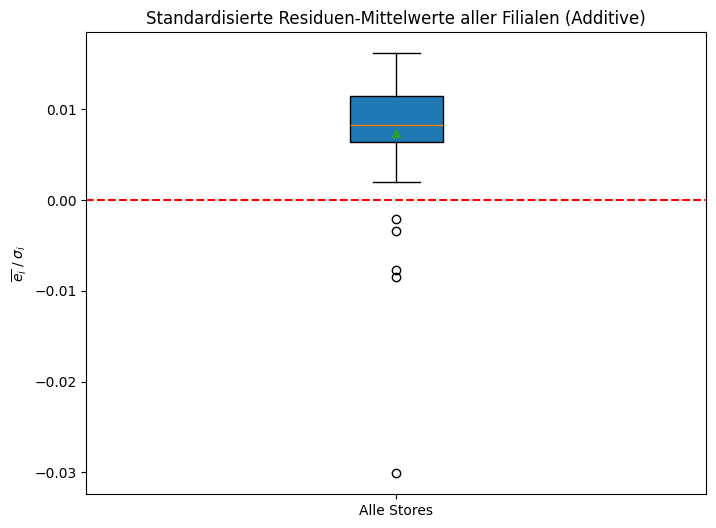

[0.008154904964496442, 0.005194927305058506, 0.0064004588466191024, 0.00871673911635864, 0.013835870044605555, 0.00683958019450436, 0.011441017238919212, 0.00789691341812474, 0.014347969263546147, 0.00803811700363059, 0.011137289951741559, 0.014854209154550614, 0.011319375036614966, 0.008153213703888908, 0.0048794057331752036, 0.012844295956666318, 0.011573488842746137, 0.006676152583262509, 0.006472671812765129, 0.008392013668456693, 0.009858297243282828, 0.012605014713158176, 0.0019436819436496485, 0.008405374507131455, 0.006289165730476905, 0.008275777667685226, 0.007426109527647773, 0.008672119349068834, 0.008240537139433915, -0.008507866719492468, 0.011464140277216518, 0.01084030886691117, -0.002114951498093073, 0.0059126309140266, 0.0161536560252323, -0.030091730477923986, -0.0033909157399523633, 0.01477248687771083, 0.01573715519373129, 0.007805665007442603, 0.01454349063851084, 0.005442465078916672, -0.007754068363713059, 0.010373378956563331, 0.013026851083940933]
Mittelwert: 

In [6]:
resid_bias = [] 
for store in sorted(residuals_dict.keys(), key=int):
    resid = residuals_dict[store]
    mean = resid.mean()
    std = resid.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        resid_bias.append(np.nan)
    else:
        resid_bias.append(mean / std) # standardisierter Bias

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Residuen-Mittelwerte aller Filialen ({})'.format(model_type))
plt.ylabel(r'$\overline{e_i}\; / \;\sigma_i$')
plt.xticks([1], ["Alle Stores"])
plt.axhline(0, color = 'red',ls='--')
plt.show()

print(resid_bias)
print("Mittelwert: ", np.mean(resid_bias))
print("Median: ", np.median(resid_bias))

Korrelations Tests

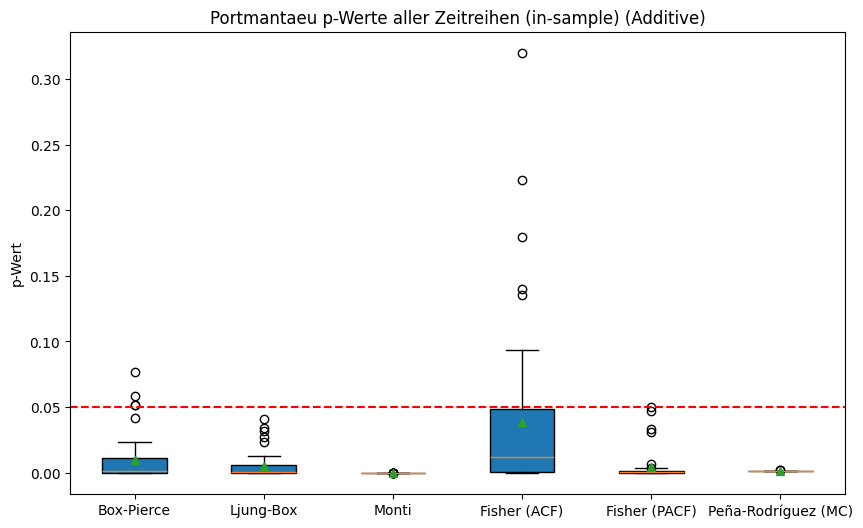

Mittelwerte: 0.009933150416507774 0.005342288414443298 1.047147321891669e-05 0.03873140492054233 0.00426483621671327 0.0010434010434010434
Mediane: 0.0013660926288550411 0.00041565771924148684 6.679495812011993e-08 0.012041653447658063 0.00026802633744493765 0.000999000999000999


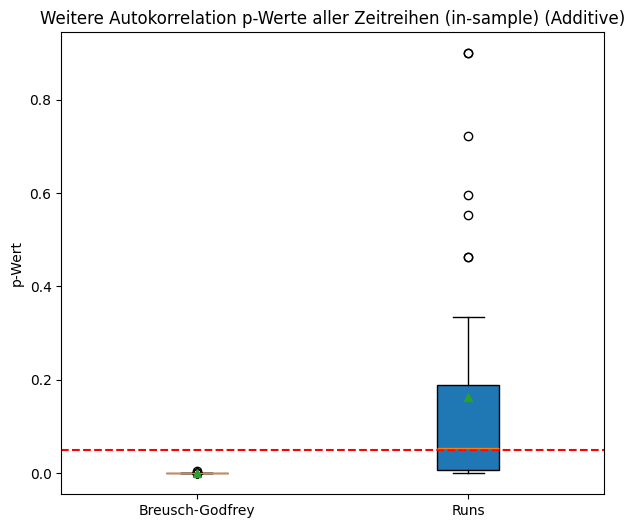

Mittelwerte: 0.00011676202148331517 0.16260837945479276
Mediane: 2.2447083998502468e-08 0.05478112645001191


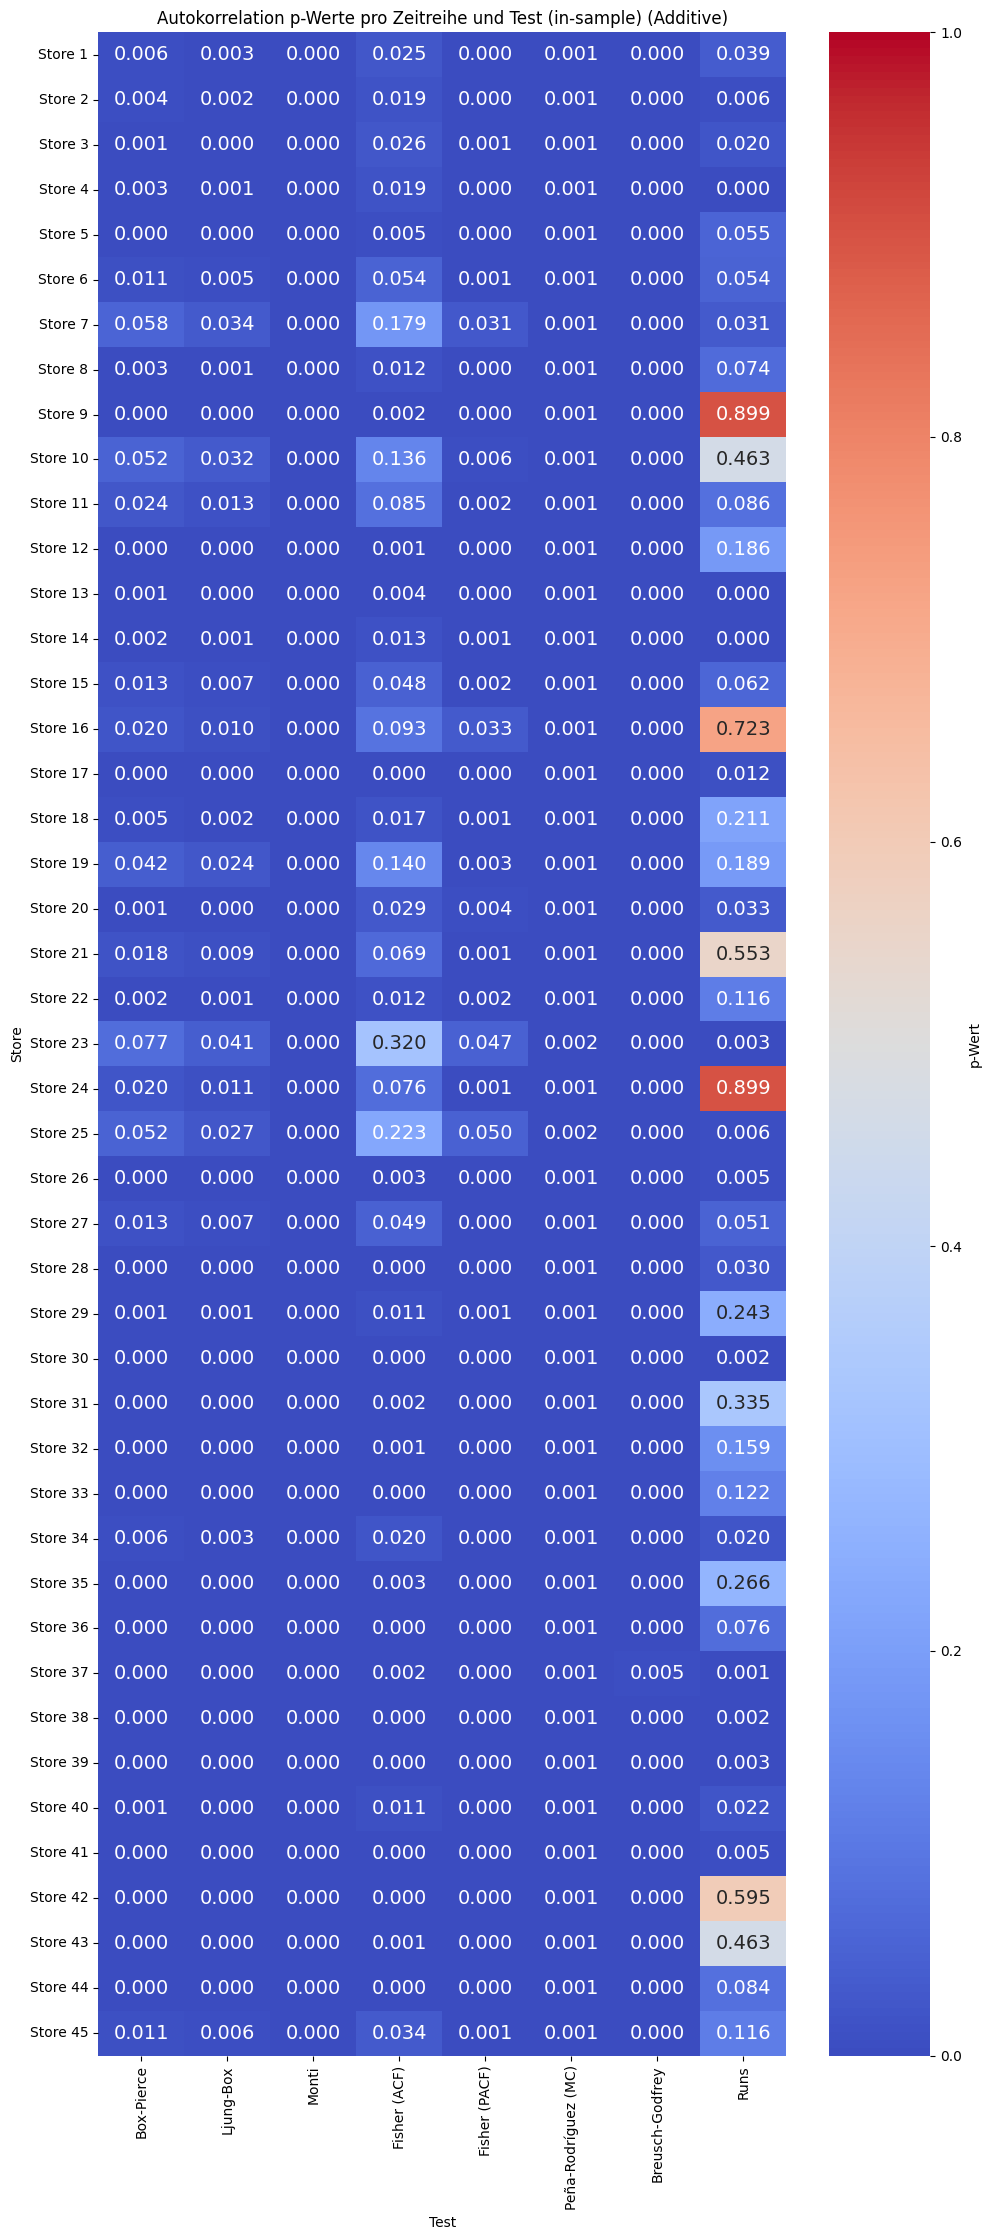

In [7]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags = 20, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags=20, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 20, print_results = False)
            if model_type == 'Additive':
                _, p_value = breusch_godfrey_manuell(sales, lags = 5, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 20, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "acf", m = 20, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "pacf", m = 20, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = resid, m = 20, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)

        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)



pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Zeitreihen (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Peña-Rodríguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print("Mediane:", np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))

# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(7, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True, widths=[0.23, 0.23])
plt.title('Weitere Autokorrelation p-Werte aller Zeitreihen (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bg_pvalues), np.mean(rt_pvalues))
print("Mediane:", np.median(bg_pvalues), np.median(rt_pvalues))

# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Peña-Rodríguez (MC)", "Breusch-Godfrey", "Runs"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelation p-Werte pro Zeitreihe und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()





Durbin Watson

[2.7146724074428352, 2.7247710301042174, 2.584930696637733, 2.7451454825392623, 2.799699075351027, 2.6215101791387987, 2.613693982582782, 2.713121400032987, 2.7225498261471484, 2.581300006195319, 2.552540386354194, 2.7138638963134607, 2.7370250050930602, 2.7677326855103495, 2.6485131718949684, 2.6776694577180664, 3.180873543872119, 2.8333389881452677, 2.7107960039892096, 2.7391683942246456, 2.5378372780372747, 2.7231138506635464, 2.577938096001692, 2.7205456860697628, 2.5587303356641904, 2.877016351872089, 2.7978766547798726, 2.9215592568771926, 2.6341782462843186, 2.961127600434091, 2.7308717348098765, 2.777339172324431, 2.333455675700808, 2.7671840821931064, 2.696113299456546, 2.6197325274422227, 3.076104339836067, 2.9837495690770344, 2.784333590343012, 2.8717564742787327, 2.90804414624634, 2.3017403598611232, 2.612068030931472, 3.160927760762069, 2.7027239445084272]


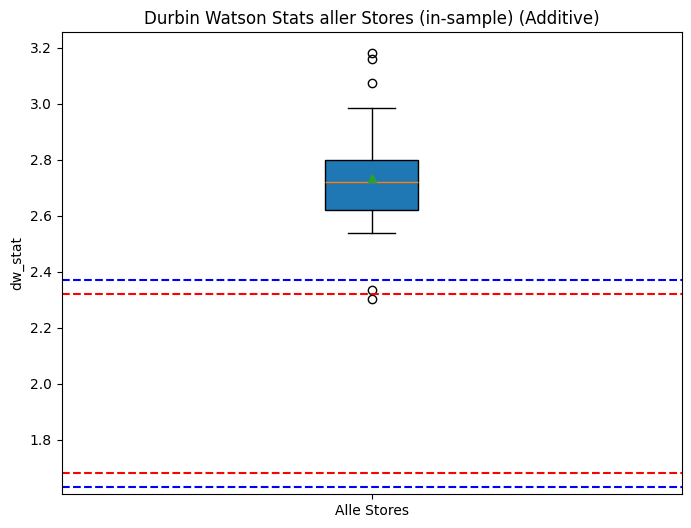

Mittelwert: 2.733755192972061
Median: 2.7225498261471484


In [8]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

print(dw_stats)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.axhline(1.68, color='red', linestyle='--', label='dU')
plt.axhline(4-1.68, color='red', linestyle='--', label='4-dU')
plt.axhline(1.63, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.63, color='blue', linestyle='--', label='4-dL')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


ACF Plots

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 3, 3, 15, 3, 3, 9, 2, 7, 4, 4, 4, 14, 9, 6, 3]
45


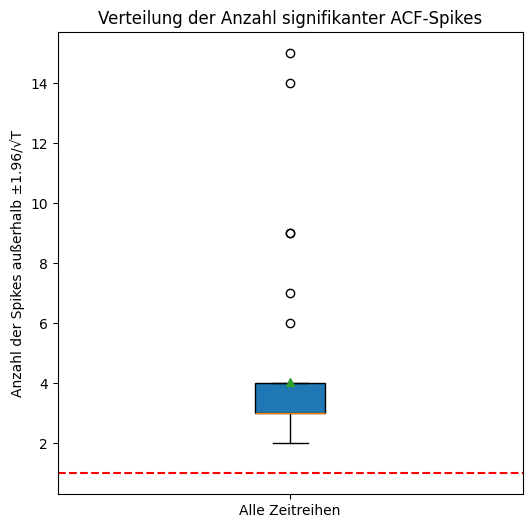

In [9]:

spikes = {}
for store in range(1, 46):
    resid = residuals_dict.get(store)
    spikes[store] = count_spikes(resid, lags = 20)
    #print(spikes[store])


values = list(spikes.values())
print(values)
print(len(values))

plt.figure(figsize=(6, 6))
plt.boxplot(values, patch_artist=True, showmeans=True)
plt.title("Verteilung der Anzahl signifikanter ACF-Spikes")
plt.ylabel("Anzahl der Spikes außerhalb ±1.96/√T")
plt.xticks([1], ["Alle Zeitreihen"])
plt.axhline(20*0.05, color='red', linestyle='--')
plt.show()



Mittelwert Tests

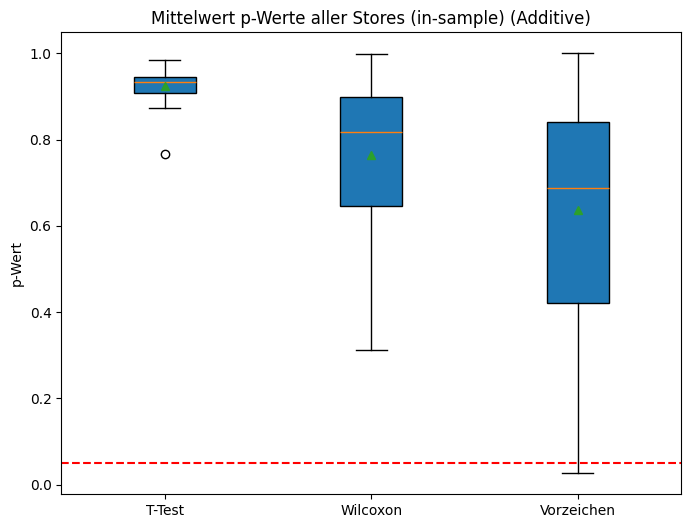

Mittelwerte: 0.9237449470101899 0.7638937723726653 0.636286951285187
Mediane: 0.9338551144311086 0.817259791460541 0.6878853435796914


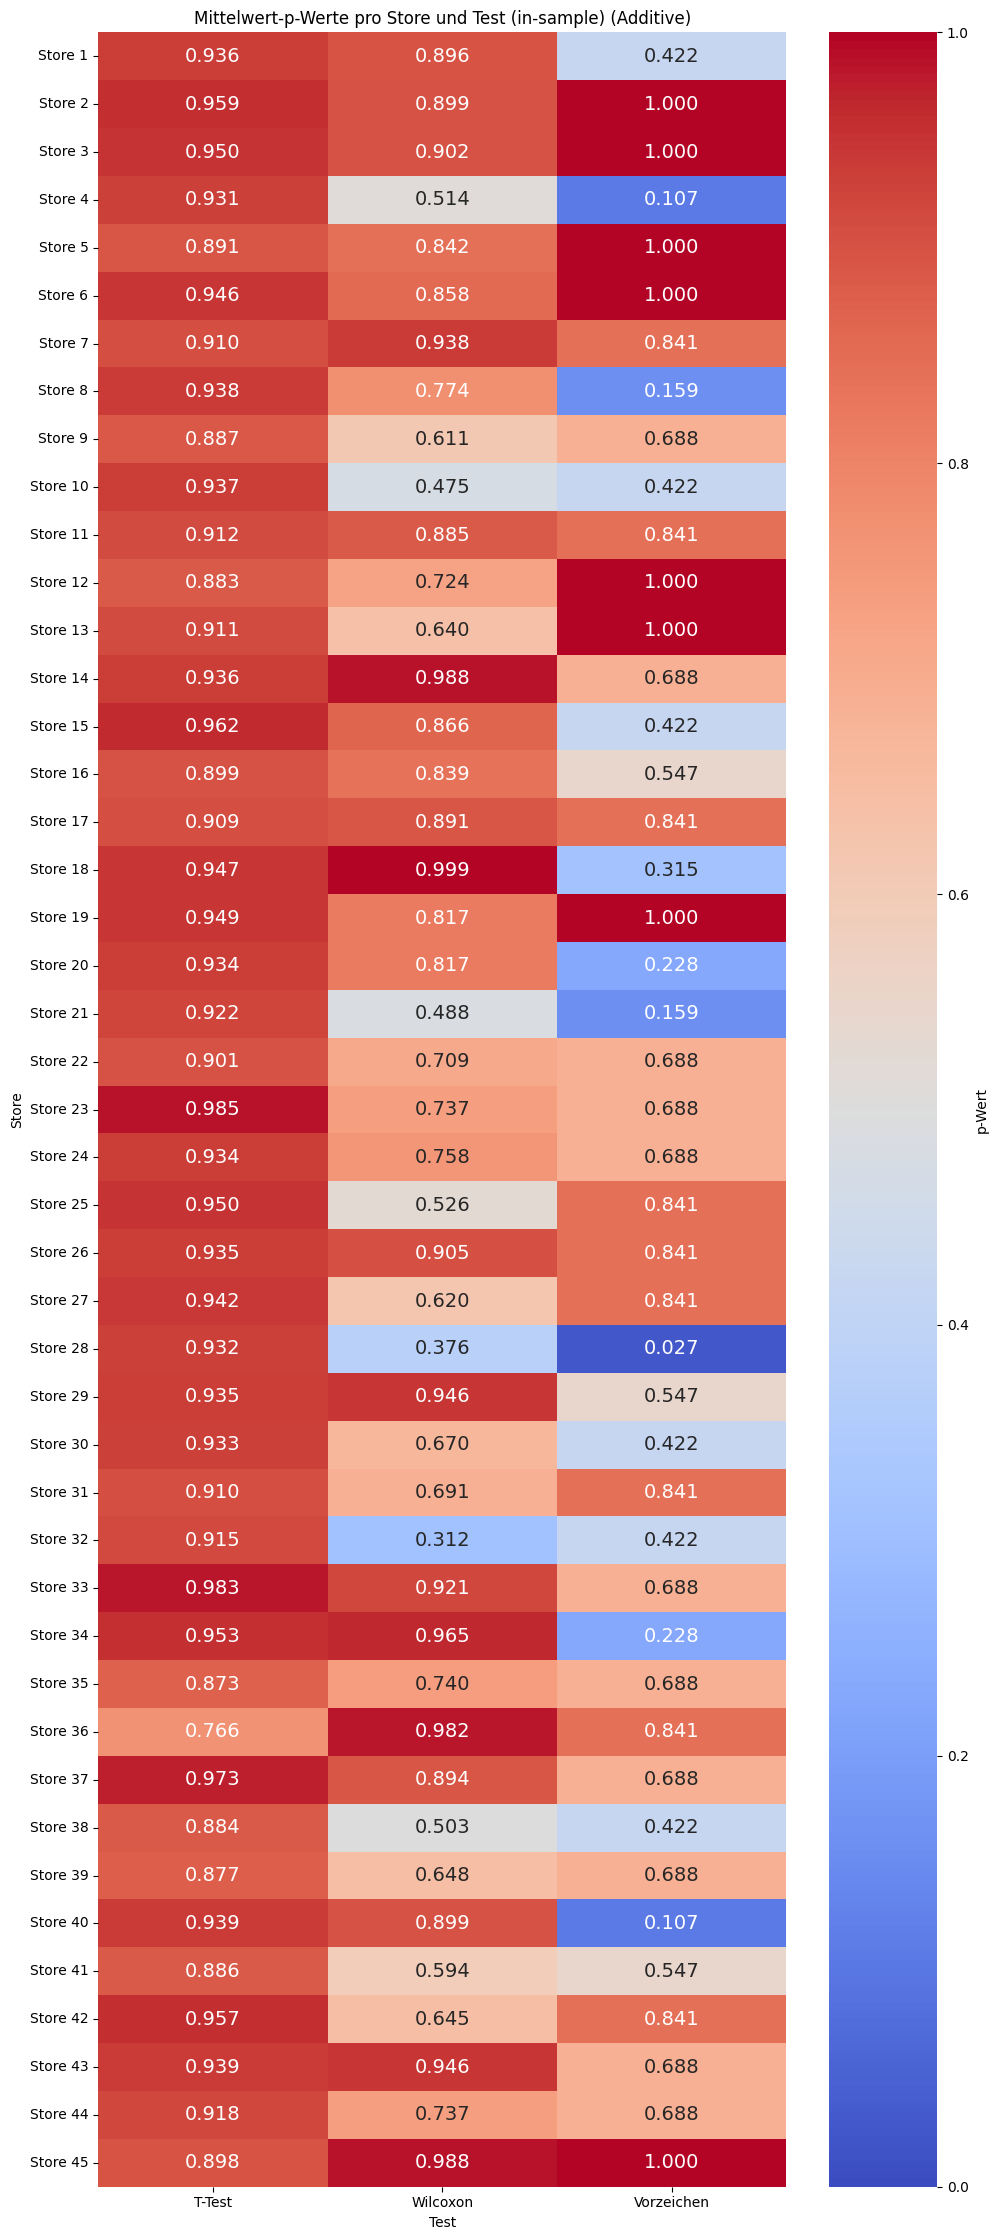

In [10]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(resid, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(resid, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3], ["T-Test", "Wilcoxon", "Vorzeichen"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(s_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(s_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["T-Test", "Wilcoxon", "Vorzeichen"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Mittelwert-p-Werte pro Store und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()

SMAPE

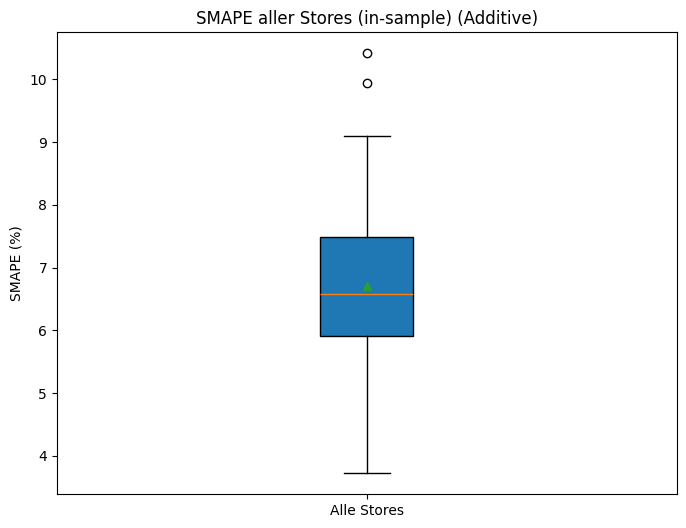

Mittelwert: 6.706795282592895 %
Median: 6.5767034589613775 %
[5.9530026965794205, 5.902598000158378, 6.634969384029605, 5.653606797355883, 6.835319801056889, 6.290592231012177, 7.293410797888406, 6.027232348716425, 5.971220969291638, 5.529742918031621, 6.075476099346715, 6.324373528850595, 6.00889744942883, 9.098313019616052, 8.139124673088036, 6.703957945045948, 7.698820513030115, 9.00344638216611, 6.75343684838903, 7.232735359792149, 6.946826563677347, 7.65531919899279, 8.84546397983731, 7.486637060972049, 6.514385940175002, 7.020733043698399, 8.76148097527435, 9.949240511795617, 8.6903508114113, 3.7310702821114927, 5.110637275121996, 5.195027548440403, 6.721298060777749, 5.420999664687818, 10.41650270626857, 4.882433288926234, 3.721643296745104, 5.436395783943512, 6.215134977504002, 7.439729590247428, 6.4589893607240505, 6.5767034589613775, 4.768101082130463, 4.717821255795954, 7.992584235585911]


In [11]:
smape_stats = []

for store in range(1, 46):
    y_train = y_train_dict.get(store) # wahre Werte
    fitted = fitted_values_dict.get(store) # geschätzte Werte

    # SMAPE berechnen

    denom = (np.abs(y_train) + np.abs(fitted))
    # Vermeide Division durch 0
    mask = denom != 0
    smape = 100 * np.mean(2 * np.abs(fitted[mask] - y_train[mask]) / denom[mask])
    smape_stats.append(smape)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)


SMAPE vs. Autokorrelation p-Werte

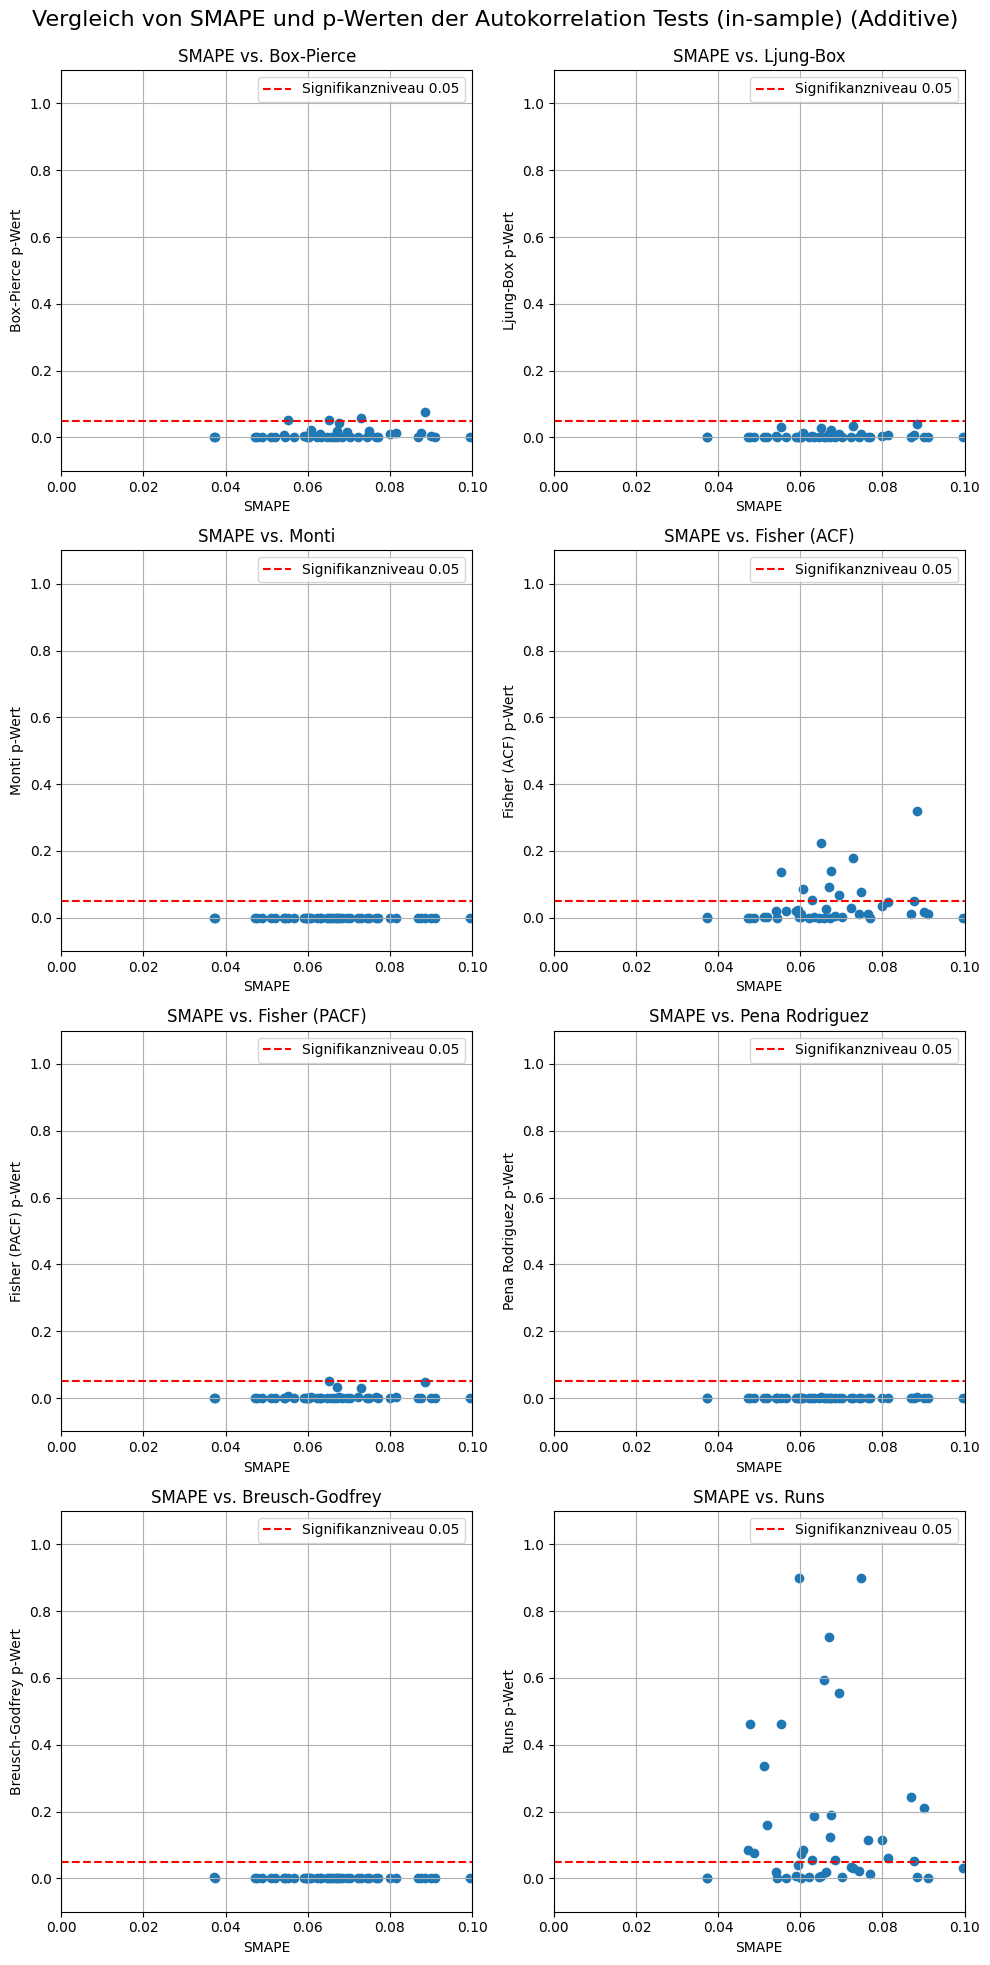

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))  # 2 Zeilen, 4 Spalten

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (in-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

SMAPE vs Mittelwert p-Werte

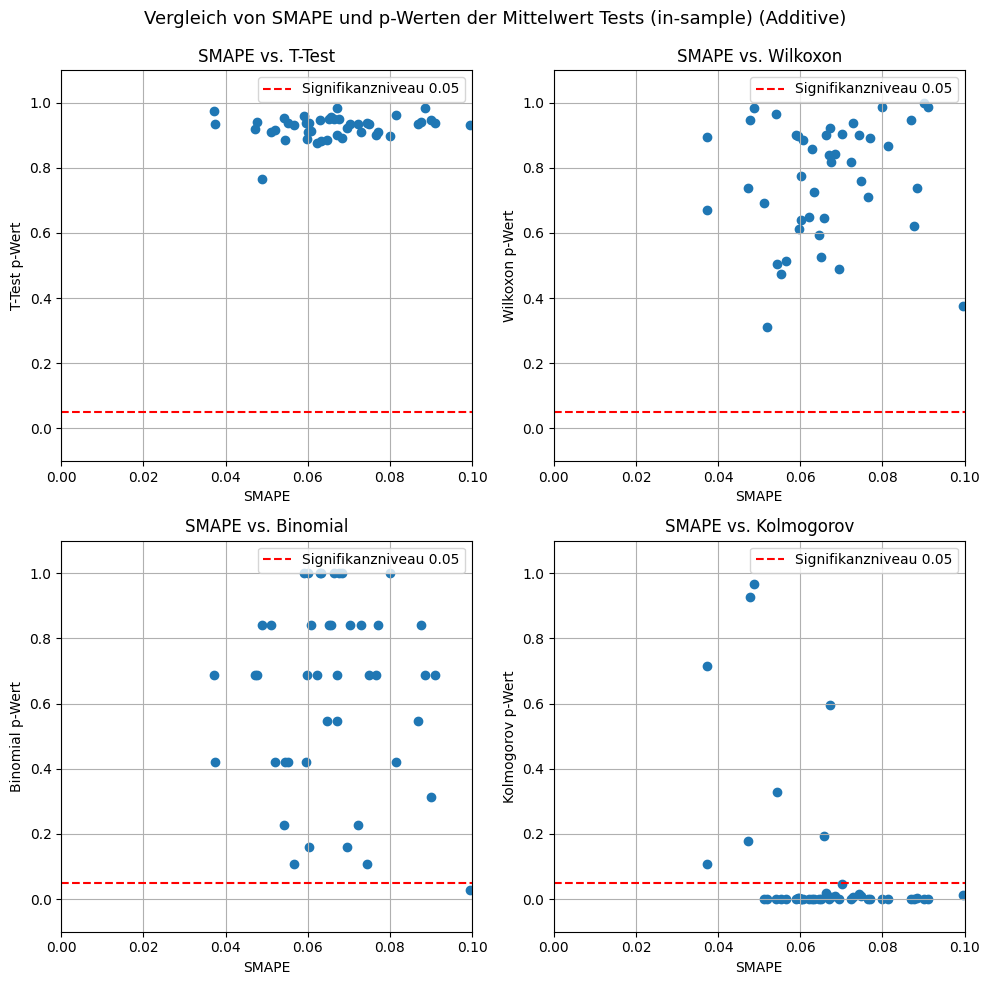

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (in-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

Errors

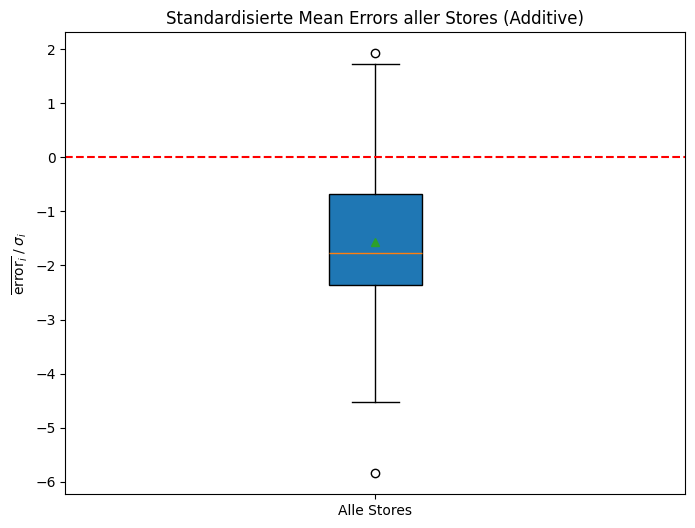

Mittelwert:  -1.5658291756708929
Median:  -1.7656456837397612


In [14]:
error_bias = [] 
for store in sorted(errors_dict.keys(), key=int):
    error = errors_dict[store]
    mean = error.mean()
    std = error.std(ddof=0)        # Populations-Std (ddof=0)
    if std == 0:
        error_bias.append(np.nan)
    else:
        error_bias.append(mean / std) # standardisierter Bias


plt.figure(figsize=(8, 6))
plt.boxplot(error_bias, patch_artist=True, showmeans=True)
plt.title('Standardisierte Mean Errors aller Stores ({})'.format(model_type))
plt.ylabel(r'$\overline{\mathrm{error}_i}\; / \;\sigma_i$')
plt.xticks([1], ['Alle Stores'])
plt.axhline(0, color = 'red', ls='--')
plt.show()

print("Mittelwert: ", np.mean(error_bias))
print("Median: ", np.median(error_bias))


Korrelations Test

Fehler beim Breusch-Godfrey Test für Store 1: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 2: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 3: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 4: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 5: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 6: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 7: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 8: breusch_godfrey_manuell() got an unexpected keyword argument 'residuals'
Fehler beim Breusch-Godfrey Test für Store 9: br

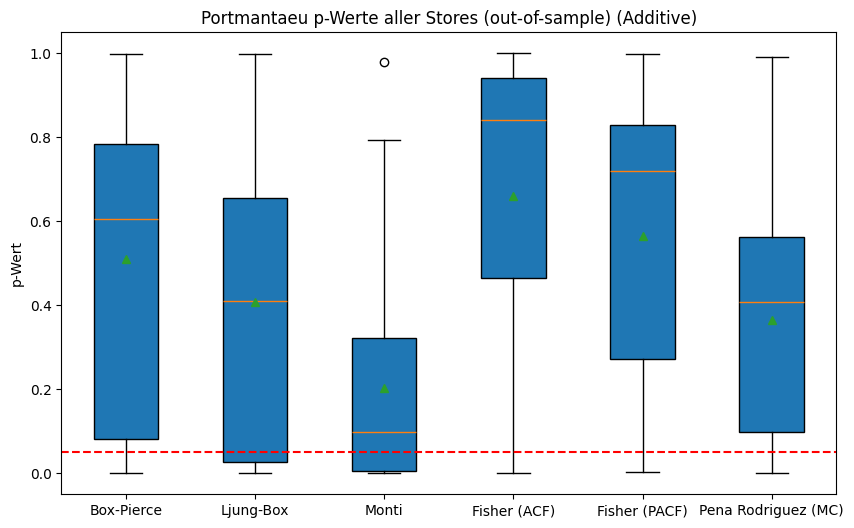

Mittelwerte: 0.51047053881015 0.40718499750817005 0.20409052914783427 0.6609822795617349 0.5652898832238443 0.36587856587856593
Mediane: 0.6042946552433819 0.41085852123291977 0.0986930590985946 0.841549396679959 0.719173859595365 0.4085914085914086


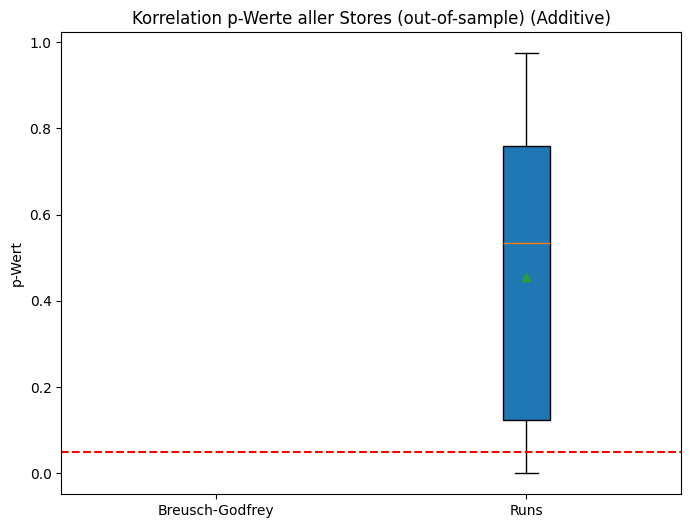

Mittelwerte: nan 0.4554139959623422
Mediane: nan 0.5343877048785454


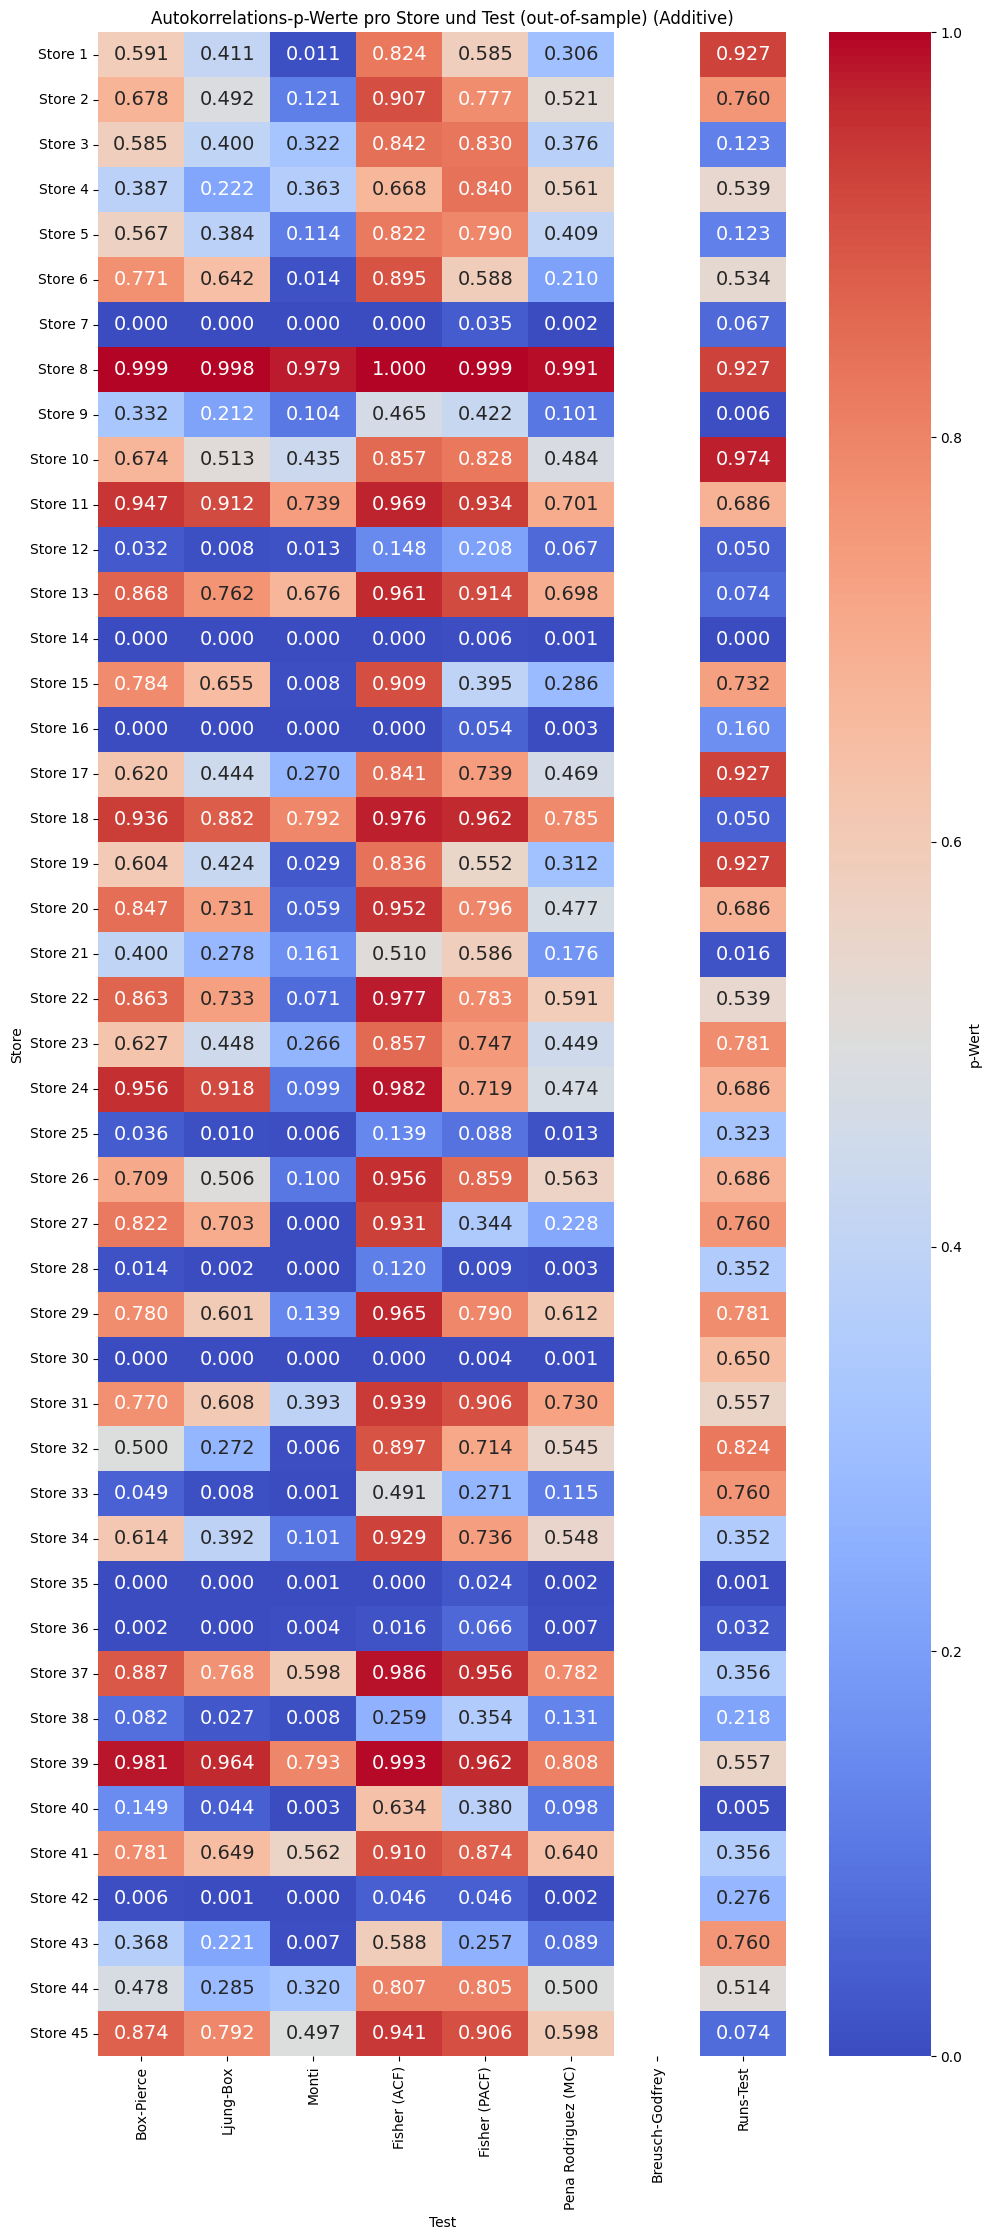

In [15]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 12, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 12, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_manuell(residuals=errors, lags = 12)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 12, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "acf", m = 12, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "pacf", m = 12, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = errors, m = 12, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print("Mediane:", np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))


# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bg_pvalues), np.mean(rt_pvalues))
print("Mediane:", np.median(bg_pvalues), np.median(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


Durbin Watson

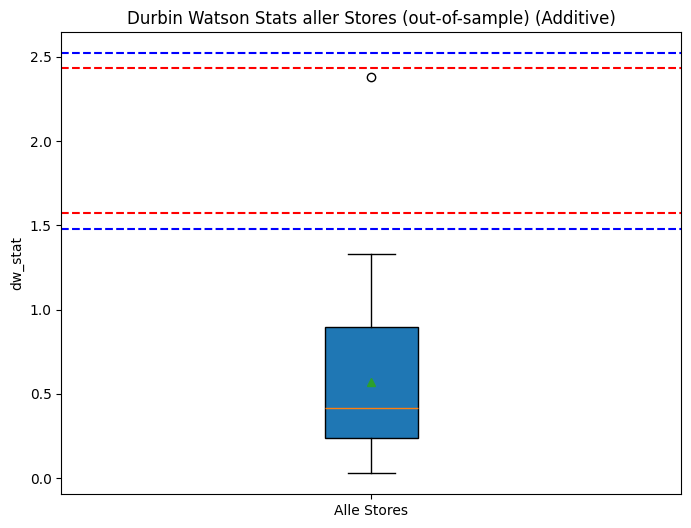

Mittelwert: 0.5710190557778527
Median: 0.41461852500354784


In [16]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = errors_dict.get(store) #Errors für den Store
    if error is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.axhline(1.57, color='red', linestyle='--', label='dU')
plt.axhline(4-1.57, color='red', linestyle='--', label='4-dU')
plt.axhline(1.48, color='blue', linestyle='--', label='dL')
plt.axhline(4-1.48, color='blue', linestyle='--', label='4-dL')
plt.show()

print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


Mittelwert Tests

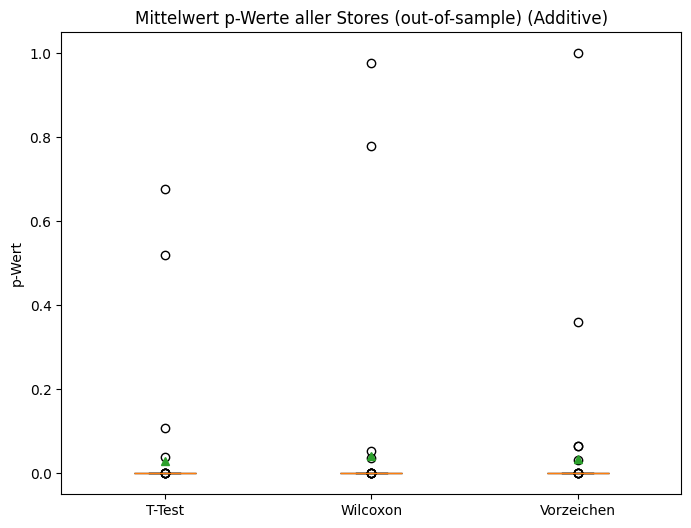

Mittelwerte: 0.029811199819544124 0.040966710243416554 0.033866473111008114
Mediane: 1.4907218916849957e-14 5.6843418860808015e-12 1.000444171950221e-11


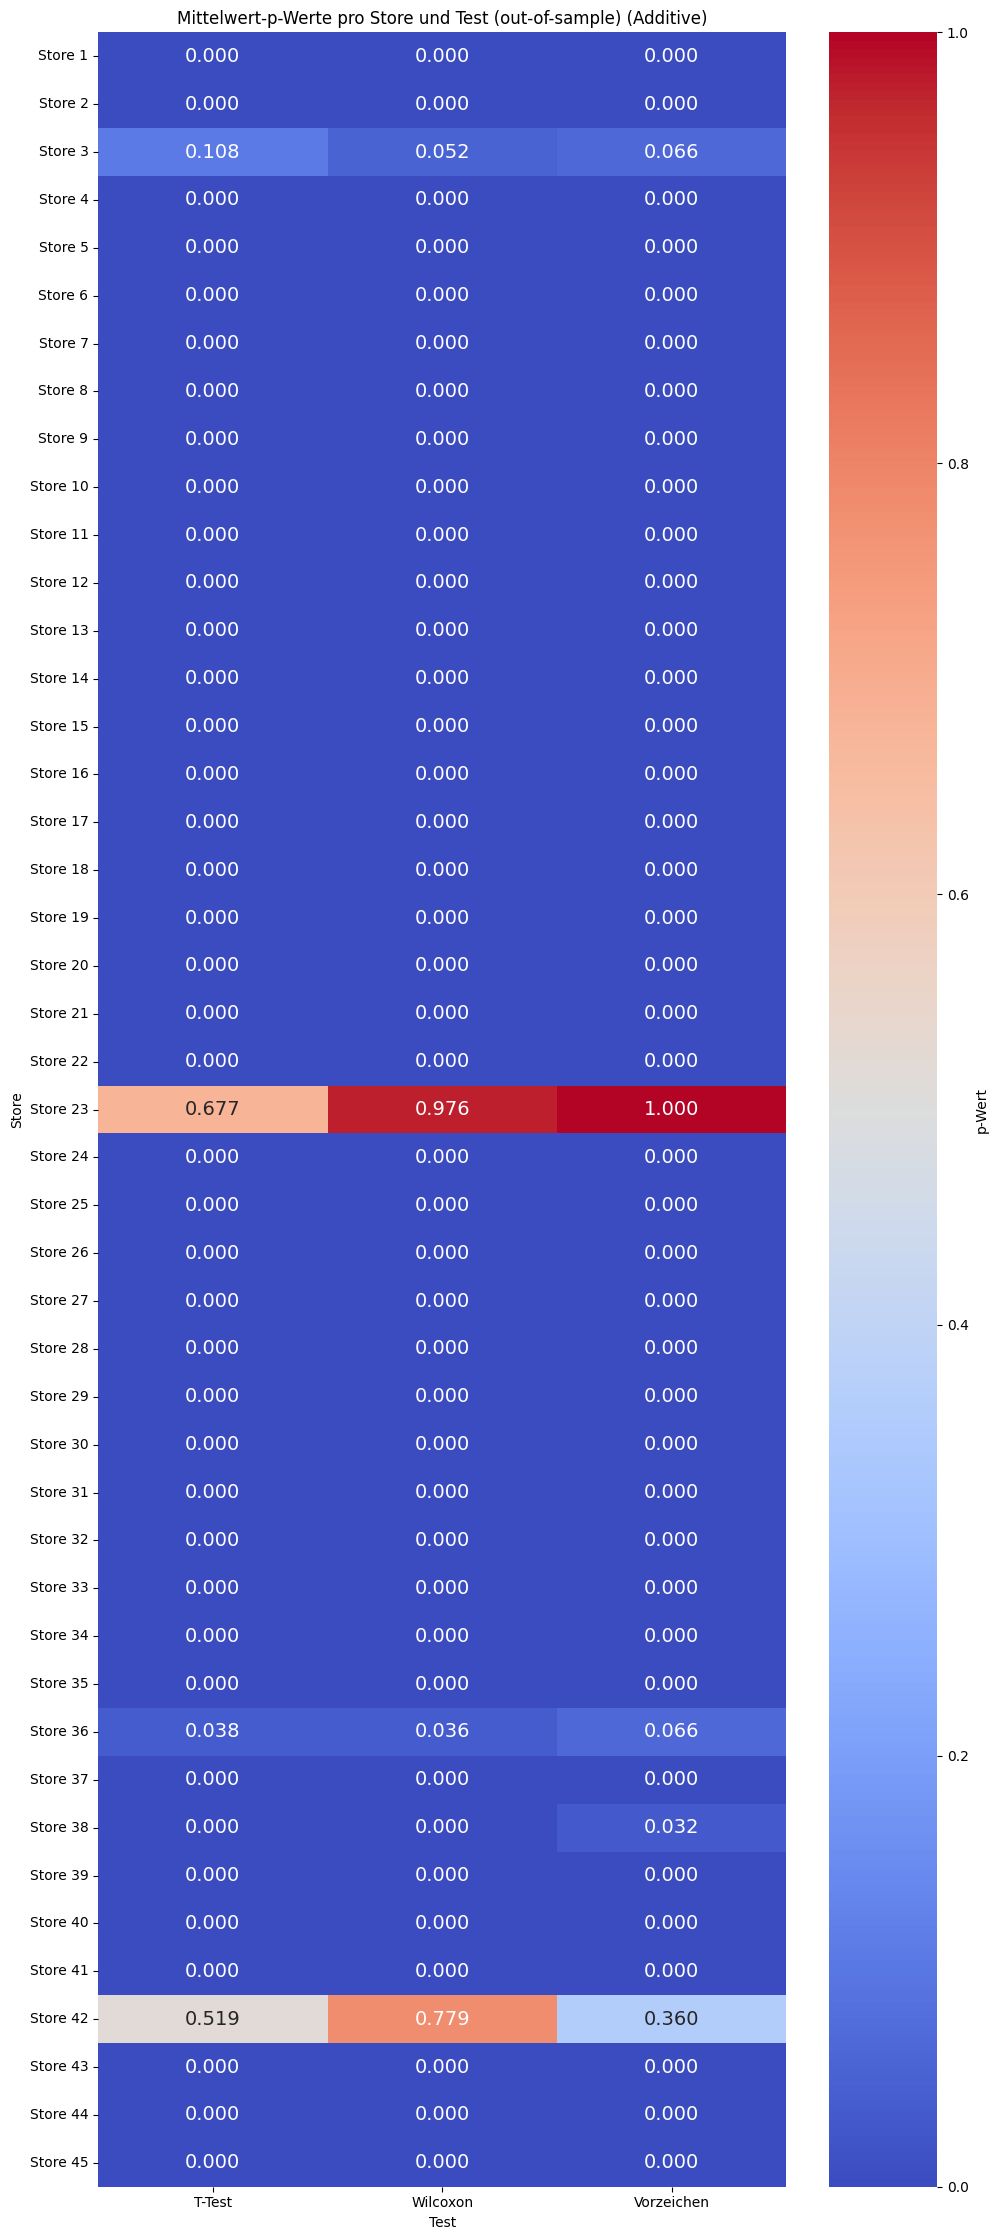

In [17]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []
s_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = errors_dict.get(store)
    if errors is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Sign Test
        try:
            _, s_value = vorzeichen_test(errors, False)
            s_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Sign Test für Store {store}: {e}")
            s_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(errors, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, s_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3], ["T-Test", "Wilcoxon", "Vorzeichen"])
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(s_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(s_pvalues))

# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["T-Test", "Wilcoxon", "Vorzeichen"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", annot_kws={"size": 14}, cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Mittelwert-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


SMAPE

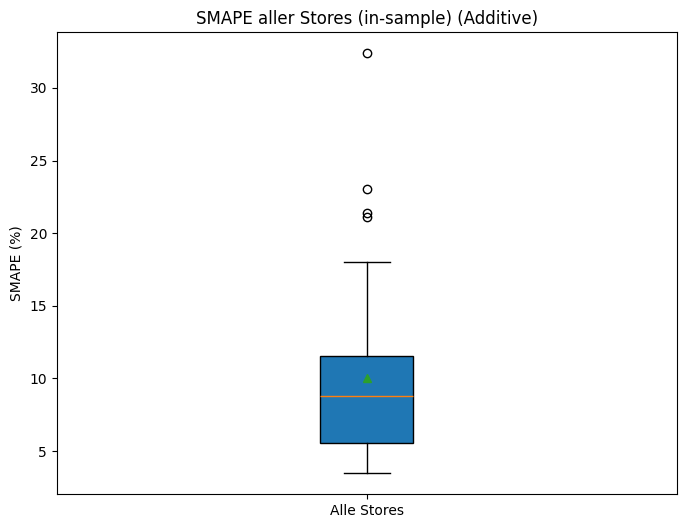

Mittelwert: 10.061110882195074 %
Median: 8.811175704332884 %
[4.50578755962276, 4.086493150896147, 4.0546608360299725, 5.167883386613283, 8.139300804839152, 5.529297348333985, 9.98527784047881, 6.1637437363705, 10.704872011670279, 11.160813815696036, 9.686485742543272, 16.520254875108694, 9.702845085788915, 23.040001062633127, 11.576970444475458, 14.888089043539798, 7.863487314050216, 8.443162405116645, 9.787052591758222, 8.811175704332884, 21.379013569136923, 18.021614423504413, 4.825770676936051, 9.625661757047324, 5.649432900924901, 7.1290399219900085, 14.242561162966513, 14.059497372915155, 14.285195062794179, 8.234420338152217, 10.852301373785084, 9.405171135098755, 8.217441684364871, 3.4730453646282924, 32.38059011195855, 5.428378617086913, 3.7181501786516824, 5.464495530073397, 10.0407404500104, 8.069173508069829, 12.193121138679116, 3.769056666217259, 7.034260093795199, 4.309176667482774, 21.125025232610454]


In [18]:
smape_stats = []

for store in range(1, 46):
    y_test = y_test_dict.get(store) # wahre Werte
    forecast = forecast_dict.get(store) # geschätzte Werte

    # SMAPE berechnen

    denom = (np.abs(y_test) + np.abs(forecast))
    # Vermeide Division durch 0
    mask = denom != 0
    smape = 100 * np.mean(2 * np.abs(forecast[mask] - y_test[mask]) / denom[mask])
    smape_stats.append(smape)

# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")
print(smape_stats)

SMAPE vs. Autokorrelation p-Werte

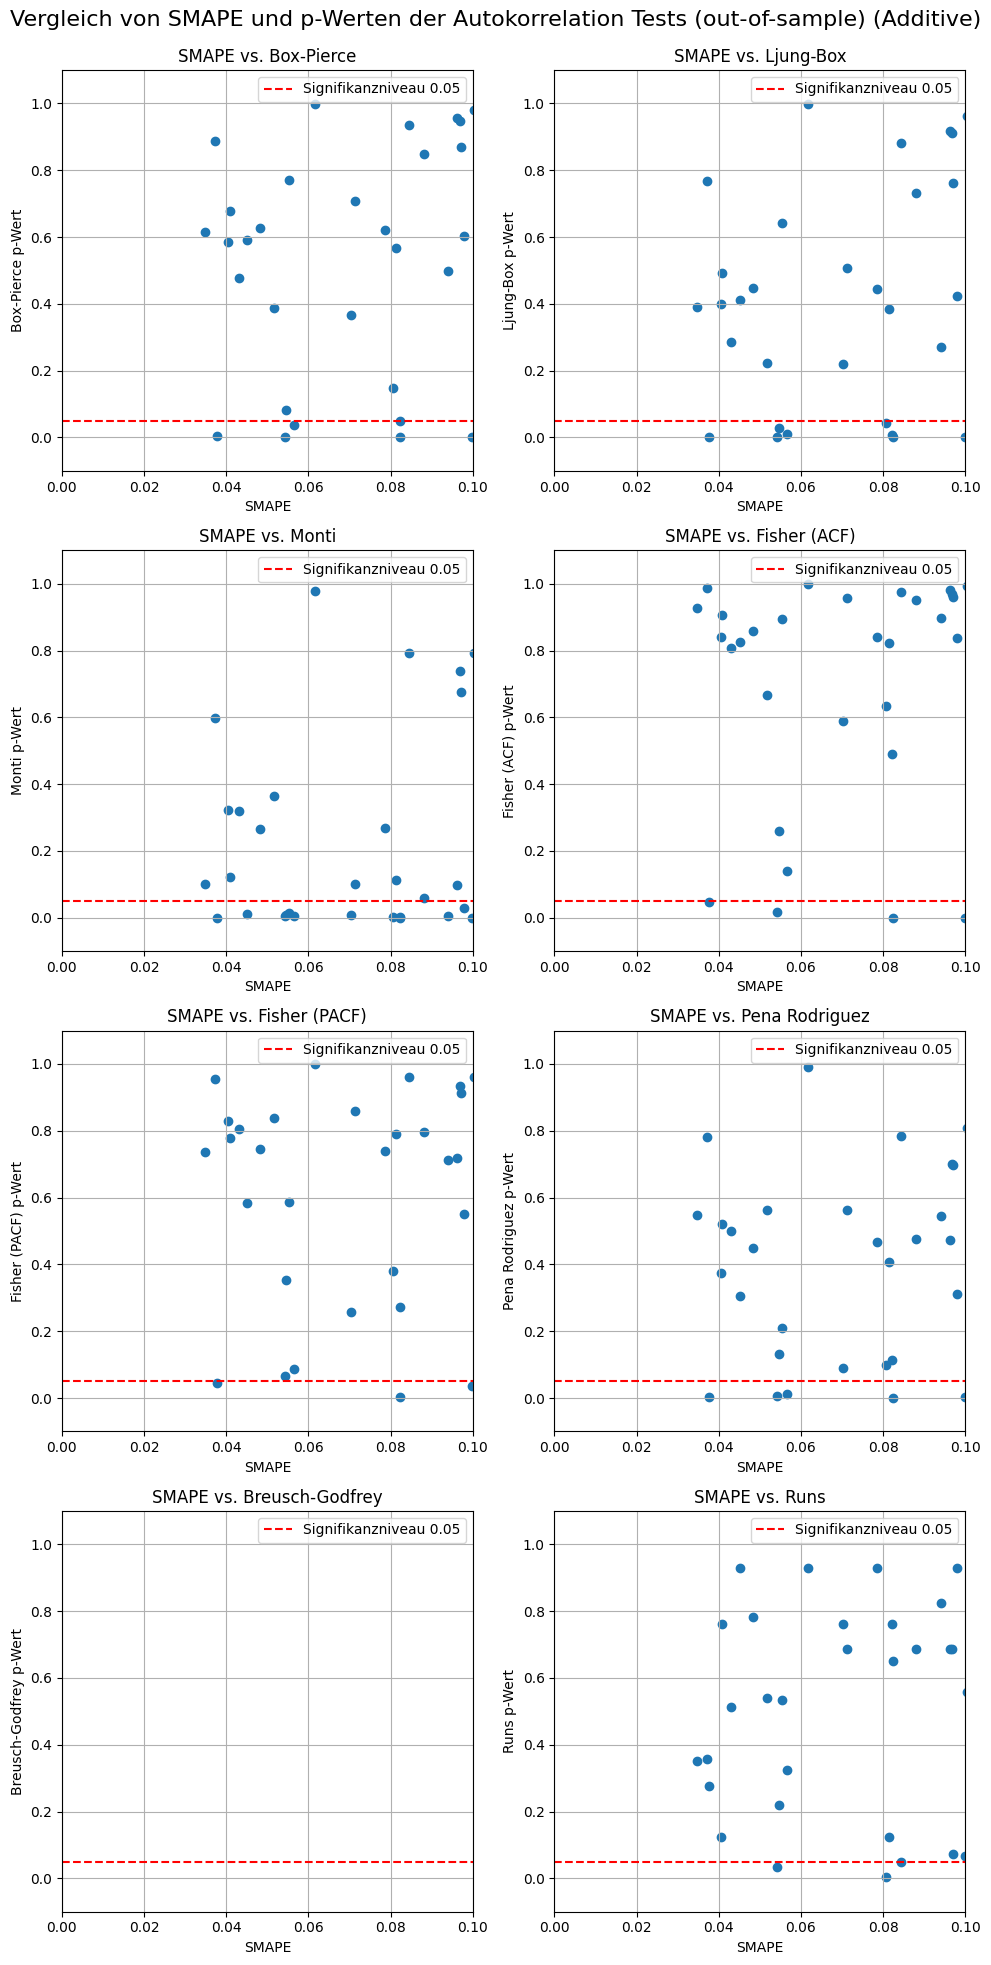

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

SMAPE vs. Mittelwert p-Werte

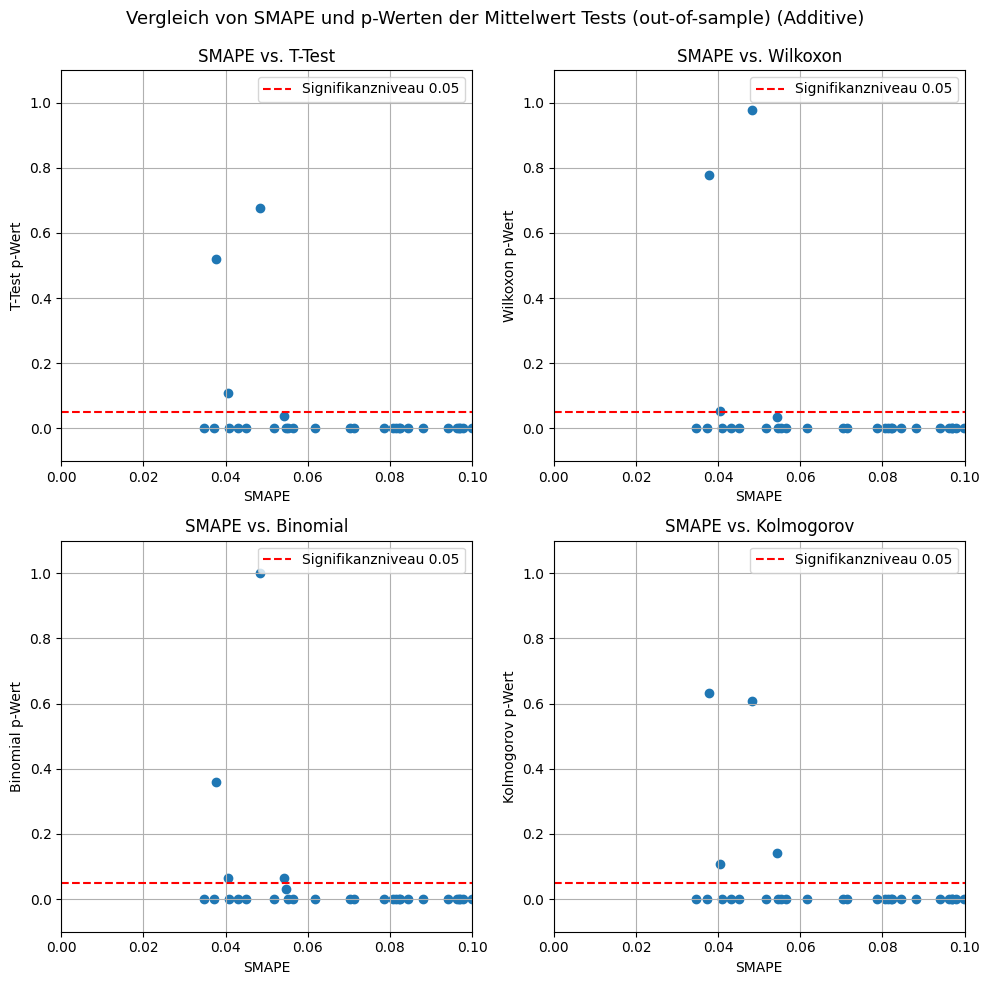

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

smape_dec = np.asarray(smape_stats) / 100
p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_dec, p_values_list[i])
    ax.set_xlabel('SMAPE')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 0.1)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()